**Preamble**

This is a **group** assignment. Please indicate the names of all group members below. 
Each group is to comprise *four* to *five* members.

If the group obtains a solution through research (e.g., on the web), then the group is to acknowledge the source, but *write up the solution in their OWN WORDS*.

## Traveling Salesperson Problem (TSP)

If you need help on using iPython notebooks, click <a href='#help'>here</a>. 

Assignment objectives:

i. Using PuLP and techniques from Dantzig, Fulkerson, Johnson (refer to lecture notes),
implement a routine to compute a lower bound for a TSP instance.

ii. Using the implemented routine, obtain tight estimates on two TSP instances.

**(a) (5 marks)** Implement a routine in PuLP that computes a lower bound for a TSP instance.

Specifically, your routine should take as 

**inputs:**

- a list of `cities`,
- a distance dictionary `dist`,
- a list of subtours `S`,

and **output** a number $L_1$ such that the shortest TSP tour for `cities`, `dist` is at least $L_1$. 

<span style='color:blue'>For the example below, your routine should compute $L_1$ to be $32$.</span>

In [1]:
# Example 2 in Dantzig, Fulkerson, Johnson
# See example in class notes

cities = [1,2,3,4,5]
dist = {
               (1,2): 5,  (1,3): 6,  (1,4): 10, (1,5):8,
    (2,1): 5,             (2,3): 5,  (2,4): 12, (2,5):12,
    (3,1): 6,  (3,2): 5,             (3,4): 8,  (3,5):10,
    (4,1): 10, (4,2): 12, (4,3): 8,             (4,5):6,
    (5,1): 8,  (5,2): 12, (5,3): 10, (5,4):6,   
}

S = [
    [4,5]
]

In [2]:
#########################################################################################
#
# This code cell defines all the helper functions used below
#
#########################################################################################

from pulp import *


## This function update the LinearProblem by adding additional subtour constraints
## Note that we pass in 'prob' into the function, and 'prob' is also returned after new constraints added
def AddSubtourConstraints(prob, subtours, list_cities, X_ijs):
    for subtour in subtours:
        list_non_subtours = list(set(list_cities) - set(subtour))
        prob += (lpSum([X_ijs[(non_subtour_city, i)]
                        for non_subtour_city in list_non_subtours 
                        for i in subtour
                        if (non_subtour_city, i) in X_ijs]) >= 2)
    return prob

## Get the Full Edges and Fractional Edges from the decision variables X_ijs
def GetFullEdgesAndFractionalEdges(list_cities, X_ijs):
    edges = []
    fedges = []
    for i in list_cities:
        for j in list_cities:
            if((i,j) in X_ijs) and (X_ijs[(i,j)].varValue > 0):
                if X_ijs[(i,j)].varValue == 1:
                    edges.append((i,j))
                else:
                    fedges.append((i,j))
    return edges, fedges


## Given that fractional Edges is allowed, we are not able to fully identify subtours,
## instead, we are able to fully indentify islands, an island is a group of nodes that
## are completely detached from the rest. An island is definitely a subtour though, hence 
## this is still useful
def Identify_One_Island(subtour_cities, X_ij_s):
    
    '''
    Helper function:
        Generate one island and return it,
        it doesn't matter starting from which city
    '''
    
    ret_tour = list()
    subtour_cities_copy = subtour_cities.copy()
    
    start_city = subtour_cities[0]
    ret_tour.append(subtour_cities_copy.pop(subtour_cities_copy.index(start_city)))
    
    found_subtour = False
    
    while len(subtour_cities_copy) > 0 and not found_subtour:
        for i in subtour_cities_copy:
            if (X_ij_s[(start_city,i)].varValue > 0) or (X_ij_s[(i, start_city)].varValue > 0):
                ret_tour.append(subtour_cities_copy.pop(subtour_cities_copy.index(i)))
                start_city = i
                break
            else:
                # reaches end, but couldn't find a link, identified end of a island
                if i == subtour_cities_copy[-1]:
                    found_subtour = True
                    
    return ret_tour
       
## This function makes use of 'Identify_One_Island' above to identify all the islands.
def Identify_All_Islands(list_cities, X_ij_s):
    
    '''
    Helper function:
        Based on decision variable's value, 
        identify the list of islands INCLUDING the main island
    '''
    
    list_cities_copy = list_cities.copy()
    
    # container to hold list of islands
    ret_tours = list()
    
    while len(list_cities_copy) > 0:
        ret_tour = Identify_One_Island(list_cities_copy, X_ij_s)
        ret_tours.append(ret_tour)
        list_cities_copy = list(set(list_cities_copy) - set(ret_tour))
    return ret_tours
    
## Helper function to print the decision variable values
## useful to identify whether we still have subtours especially when RED edges exist
def Print_Cities_With_Linkage(list_cities, X_ij_s):
    for i in list_cities:
        for j in list_cities:
            if ((i,j) in X_ij_s) and (X_ij_s[(i,j)].varValue > 0):
                print(i, " to ", j, " with value of ", X_ij_s[(i,j)].varValue)
    print('\n')
    

In [3]:
#########################################################################################
#
# Question (a) Required Routine
#
#########################################################################################


def Tsp_L1(list_cities, dict_distances, list_subtour=[]):
    
    '''
    This function takes the following params
        @list_cities: the collect of cities
        @ict_dist: the collection inter-city distances
        @ist_subtour: the list of subtour, each subtour is also a list of cities
    '''
    # problem
    tspProb = LpProblem("TSP", LpMinimize)

                
    # decision variables
    X_ij_s = LpVariable.dicts('DecisionVariables', dict_distances, 0, 1, cat=LpContinuous)
    
            
    # cost 
    C_ij_s = lpSum([X_ij_s[(i,j)] * dict_distances[(i,j)]] for (i,j) in dict_distances)

    # update the prob
    tspProb  += C_ij_s

    # add the constraints
    for i in list_cities:
                     # all inbound to city i should sum up to 1
        tspProb += ( lpSum([ X_ij_s[(from_city, i)] 
                            for from_city in list_cities 
                            if (from_city, i) in X_ij_s]) 
                     # all outbound from city i should sum up to 1
                   + lpSum([ X_ij_s[(i, to_city)] 
                           for to_city in list_cities 
                           if (i, to_city) in X_ij_s]) 
                     # hence 2 here
                 == 2)
        
    for subtour in list_subtour:
        list_non_subtour = list(set(list_cities) - set(subtour))
        if (len(list_non_subtour) == 0):
            break
        
        # for each subtour make sure the numbers of links to each city in the subtour >=1
        tspProb += (lpSum([ X_ij_s[(non_subtour_city, i)] 
                            for i in subtour 
                            for non_subtour_city in list_non_subtour 
                            if (non_subtour_city, i) in X_ij_s]) 
                        >= 2)
    
    # The following constraints fulfill two purposes:
    # 1. firstly, it eliminates the two-node subtours
    # 2. secondly, it doesn't assume X_ij == X_ji, which makes more sense in the case of TSP
    #    it should be uni-directional instead of bidirectional. That means, especially in the 
    #    LpInteger/LpBinary case, X_ij = 1 and X_ji = 0. To put it simple, it added a directional
    #    constraint.
    for i in list_cities:
        for j in list_cities:
            if i != j:
                tspProb += X_ij_s[(i,j)] + X_ij_s[(j,i)] <= 1
                
    tspProb.solve()
    print(LpStatus[tspProb.status])
    print("Minimum Cost: {}".format(value(tspProb.objective)))
                    
    return tspProb,X_ij_s



#########################################################################################
#
# Question (a) Solving the example with the Routine created above
#
#########################################################################################
prob, X_ij_s = Tsp_L1(cities, dist, S)
Print_Cities_With_Linkage(cities, X_ij_s) 
example_all_islands = Identify_All_Islands(cities, X_ij_s)
print("Part (a) all islands: ", example_all_islands)


Optimal
Minimum Cost: 32.0
1  to  2  with value of  1.0
1  to  5  with value of  1.0
2  to  3  with value of  1.0
3  to  4  with value of  1.0
4  to  5  with value of  1.0


Part (a) all islands:  [[1, 2, 3, 4, 5]]


----

**(b) (10 marks)** 

For each of the two given instances, let $L^*$ be the length of a shortest TSP tour.

Using the routine in (a) (and some appropriate choices of `S`), compute a lower bound $L_1$.
From the solution in (a), guess a 'short' TSP tour and hence, obtain an upper bound $L_2$.
Therefore, 
$$L_1\le L^*\le L_2.$$

The marks to be awarded will depend the quality of your estimates, or equivalently, the ratio $L_2/L_1$. The specific mark allocation for each TSP instance is as follows.

|  &nbsp; &nbsp; &nbsp; &nbsp; Ratio $R=L_2/L_1$ &nbsp;  &nbsp; &nbsp; &nbsp;   |  Mark(s)    |
|:--------------------:|:-----------:| 
| $R>1.5$              | 0|
| $1.1 < R \le 1.5$    | 2 |
| $1.05 < R \le 1.1$ | 3 |
| $1.01 < R \le 1.05$ | 4 |
| $R \le 1.01$ | 5 |



## TSP B1

In [4]:
#########################################################################################
#
# Question B1  
# B1 Instance Part (1) Solve B1 instance without having the subtours for the first iteration
#
#########################################################################################

from TSP_B1 import *
import pulp

print("number of cities : {}".format(len(cities_B1)))

cities_B1_list = list(cities_B1)

## first iteration, we don't have any subtour
subbb = []

## calling the Routine defined in Question(a)
b1_prob, B1_X_ij_s = Tsp_L1(cities_B1_list, dist_B1)

## Print the X_ij_s which is also the linkage
Print_Cities_With_Linkage(cities_B1_list, B1_X_ij_s)

## Identify and Print all the islands
b1_all_islands = Identify_All_Islands(cities_B1_list, B1_X_ij_s)
print("B1 instance initial {0} islands: {1}".format(len(b1_all_islands), b1_all_islands))


number of cities : 45
Optimal
Minimum Cost: 1145.0
2  to  1  with value of  1.0
3  to  4  with value of  1.0
4  to  2  with value of  1.0
5  to  19  with value of  1.0
6  to  1  with value of  1.0
6  to  7  with value of  1.0
8  to  7  with value of  1.0
8  to  9  with value of  1.0
9  to  10  with value of  1.0
11  to  15  with value of  1.0
12  to  21  with value of  1.0
15  to  10  with value of  1.0
16  to  20  with value of  1.0
16  to  21  with value of  1.0
17  to  32  with value of  1.0
18  to  31  with value of  1.0
19  to  3  with value of  1.0
22  to  12  with value of  1.0
22  to  13  with value of  1.0
23  to  13  with value of  1.0
24  to  23  with value of  1.0
24  to  31  with value of  1.0
25  to  41  with value of  1.0
26  to  29  with value of  1.0
26  to  30  with value of  1.0
28  to  27  with value of  1.0
28  to  40  with value of  1.0
29  to  27  with value of  0.5
30  to  14  with value of  1.0
32  to  18  with value of  1.0
33  to  17  with value of  1.0
33  t

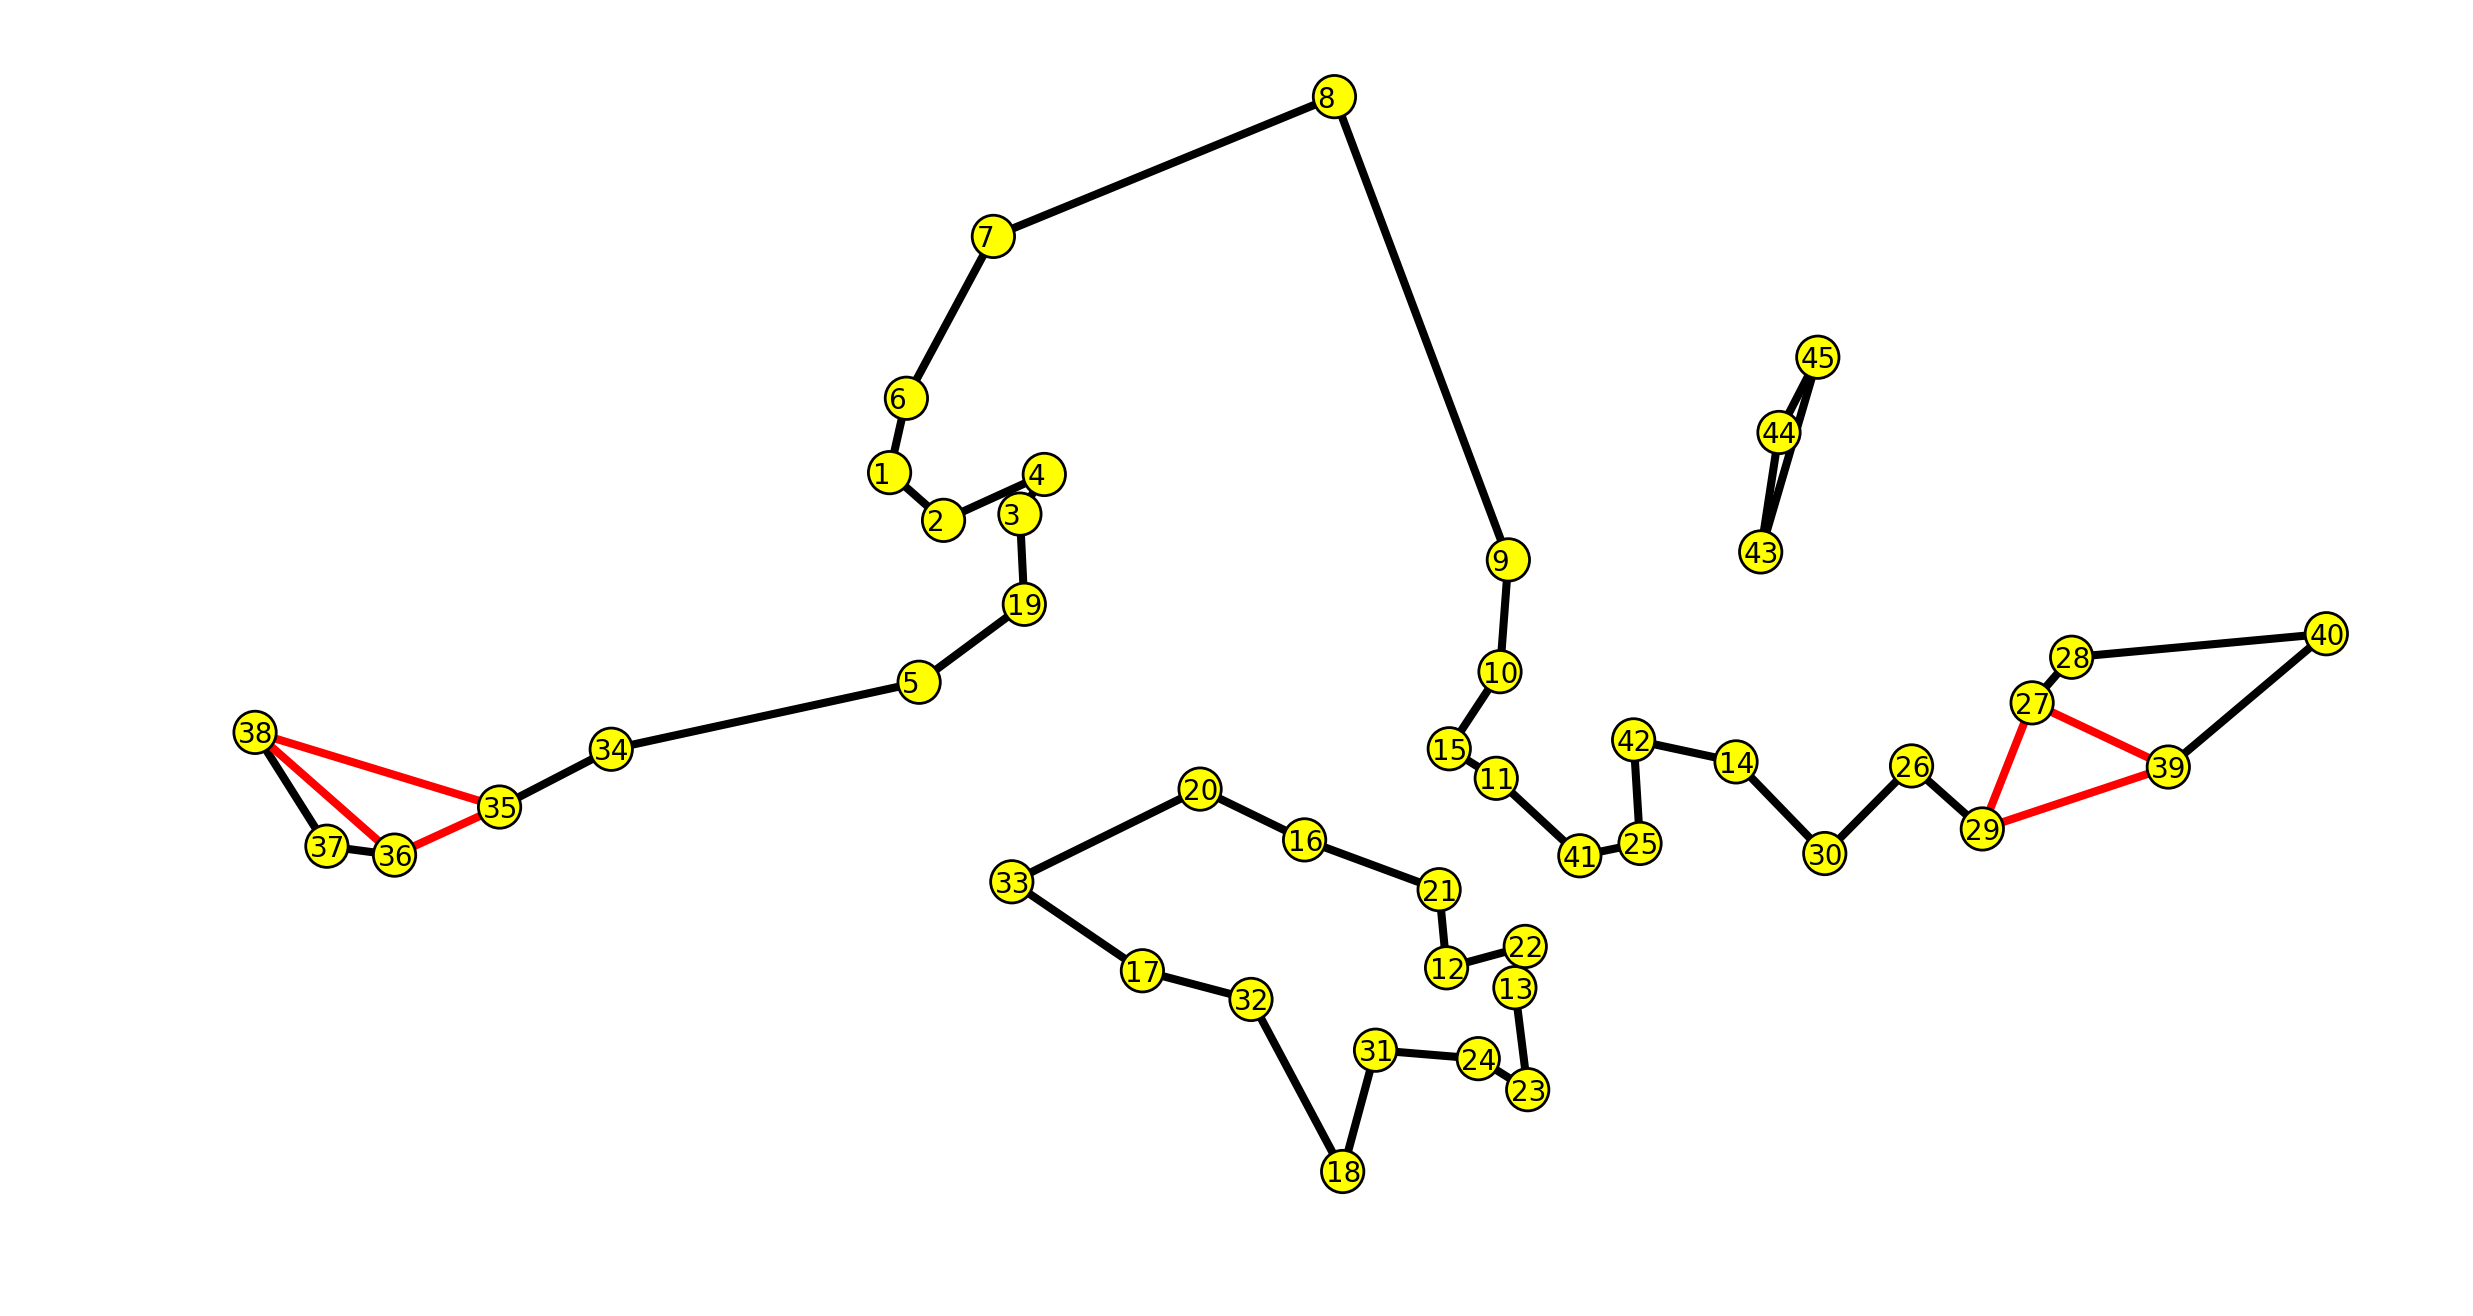

In [8]:
#########################################################################################
#
# Question B1
# B1 Instance Part (2) Plotting the initial graph
#
#########################################################################################

b1_ee, b1_ff = GetFullEdgesAndFractionalEdges(cities_B1_list, B1_X_ij_s)
b1_initial_graph = frac_TSP_plot(b1_ee, b1_ff, cities_B1_list, posn_B1,dist_B1)

In [9]:
#########################################################################################
#
# Question B1
# B1 Instance Part (3) Iteratively subtour elimination
#
#########################################################################################

## Please note that the following subtours are generated iteratively
## and new subtours can be generated whilst eliminating an existing
##
## for example, 
##   iteration 1 -> eliminating [43, 44, 45]
##   iteration 2 -> eliminating [27, 28, 39, 40]
##   after iteration 2, new subtour [26,27,28,29,39,40] was generated, 
##   iteration 3 -> eliminating new subtour [26,27,28,29,39,40]
#    ...

b1_final_subtours = [
     [43,44,45],[27,28,39,40], 
     [26,27,28,29,39,40],
     [32, 17, 33, 20, 16, 21, 12, 22, 13, 23, 24, 31, 18],
     [34,35,36,37,38],
     [36,37,38],
     [35,36,37,38],
     [5,34,35,36,37,38],
     [18,23,24,31], 
     [26,27,28,29,30,39,40],
     [27,28,29,39,40],
     [14,26,27,28,29,30,39,40]]

## Run the Routine again with the final subtours
b1_prob, B1_X_ij_s = Tsp_L1(cities_B1_list, dist_B1, b1_final_subtours)

## solve the updated b1_prob
b1_prob.solve()

print(LpStatus[b1_prob.status])

print("Minimum Cost: {}".format(value(b1_prob.objective)))

## print the new X_ij_s
Print_Cities_With_Linkage(cities_B1_list, B1_X_ij_s)


Optimal
Minimum Cost: 1308.33333305
Optimal
Minimum Cost: 1308.33333305
1  to  2  with value of  1.0
1  to  6  with value of  1.0
3  to  4  with value of  1.0
4  to  2  with value of  1.0
5  to  34  with value of  1.0
7  to  6  with value of  1.0
8  to  7  with value of  1.0
8  to  45  with value of  1.0
9  to  10  with value of  1.0
9  to  43  with value of  0.5
9  to  44  with value of  0.5
10  to  11  with value of  0.33333333
11  to  21  with value of  0.66666667
12  to  13  with value of  0.33333333
12  to  21  with value of  1.0
12  to  24  with value of  0.33333333
12  to  31  with value of  0.33333333
13  to  23  with value of  0.66666667
14  to  30  with value of  1.0
15  to  10  with value of  0.66666667
15  to  11  with value of  1.0
15  to  16  with value of  0.33333333
16  to  20  with value of  1.0
16  to  21  with value of  0.33333333
16  to  32  with value of  0.33333333
17  to  20  with value of  0.5
17  to  32  with value of  1.0
18  to  23  with value of  0.33333333


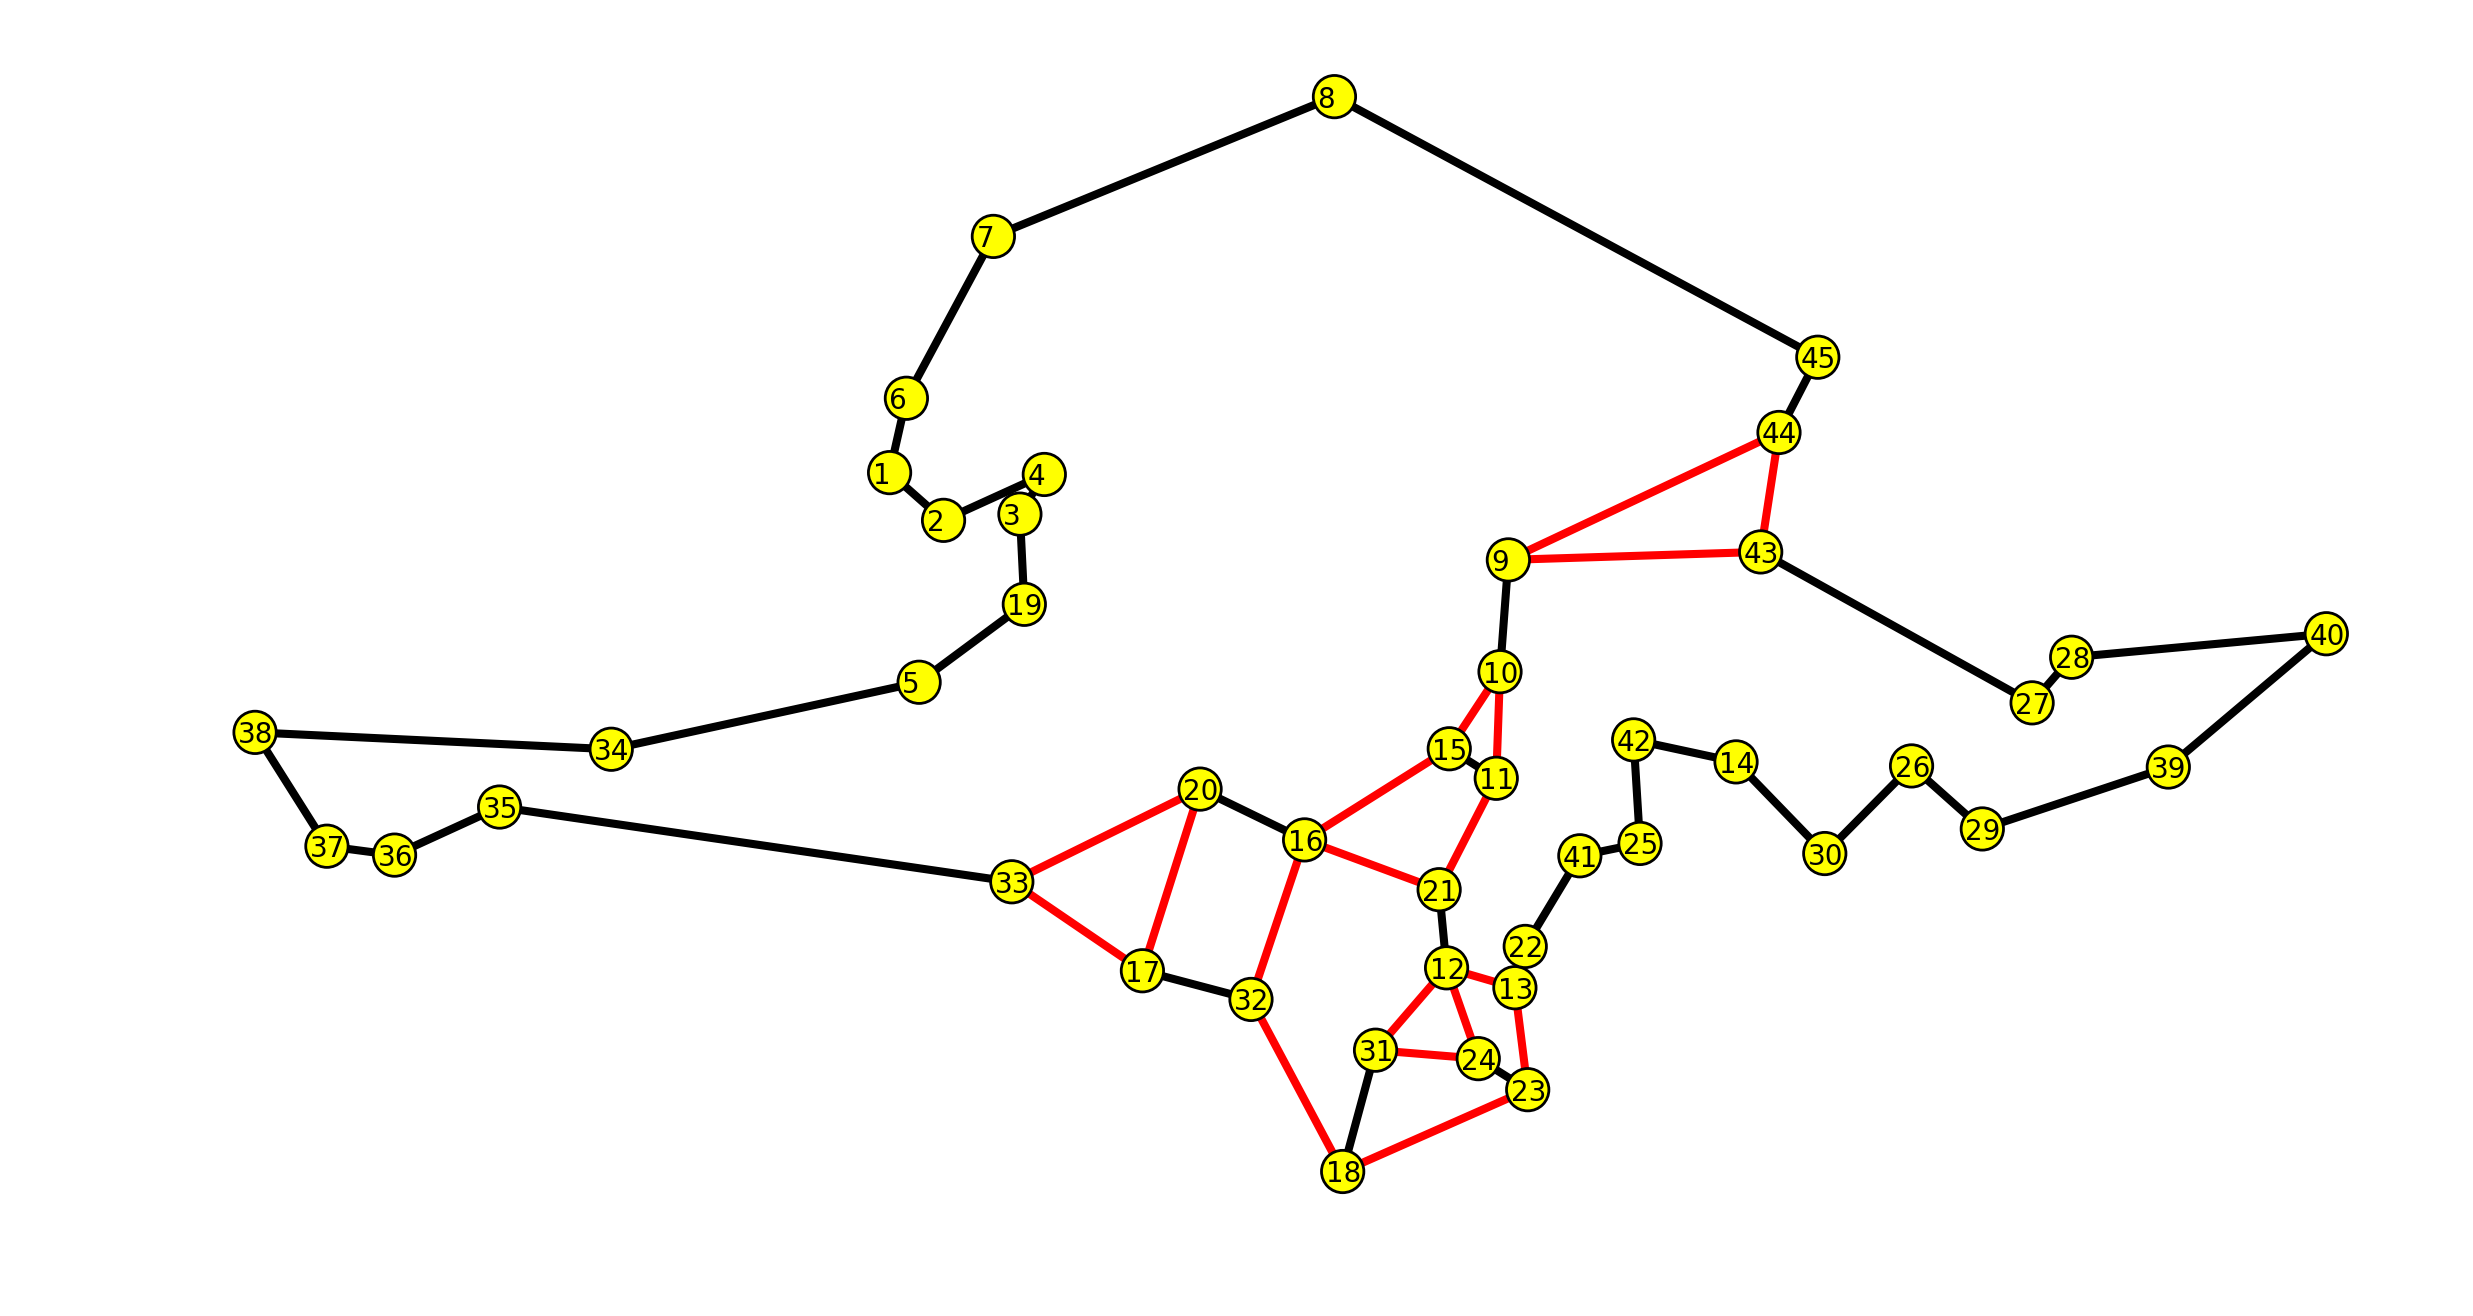

In [10]:
#########################################################################################
#
# Question B1 
# B1 Instance Part (4) Plotting the final graph
#
#########################################################################################
b1_ee_final, b1_ff_final = GetFullEdgesAndFractionalEdges(cities_B1_list, B1_X_ij_s)
b1_final_graph = frac_TSP_plot(b1_ee_final, b1_ff_final, cities_B1_list, posn_B1,dist_B1)


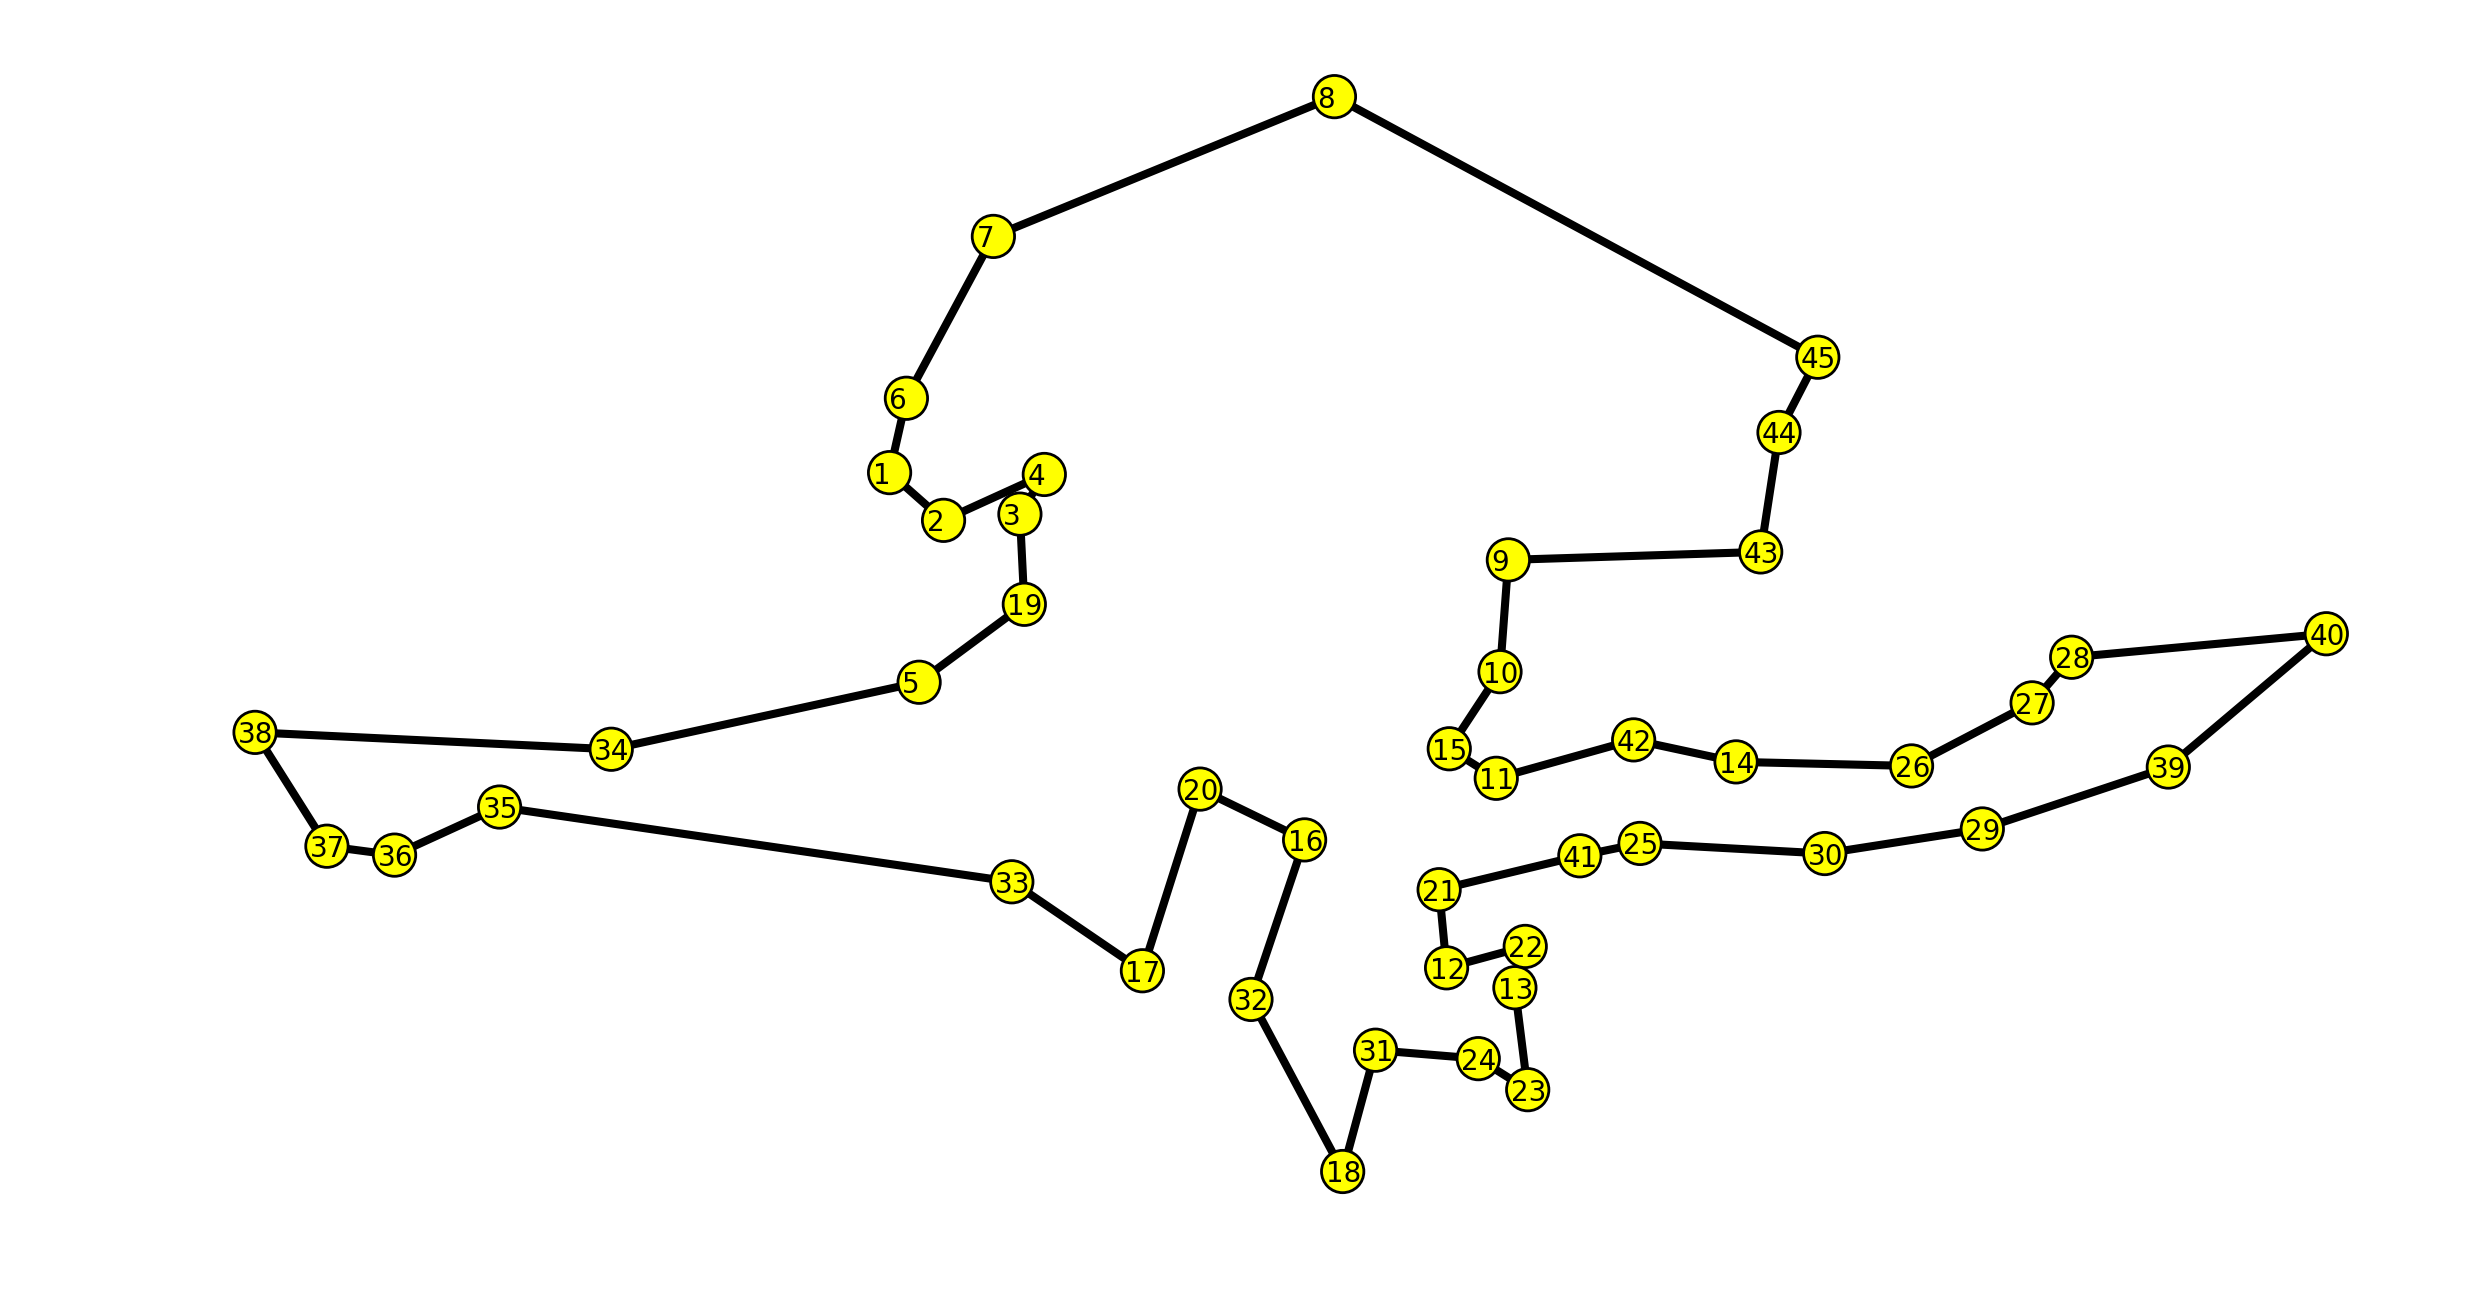

length of candidate TSP tour : 1316


In [11]:
#########################################################################################
#
# Question B1
# B1 Instance Part (5) Plotting the candidate tour
#
#########################################################################################

b1_candidate_tour = [
    8,45,44,43,9,10,15,11,
    42,14,26,27,28,40,39,29,30,
    25,41,21,12,22,13,23,24,31,18,
    32,16,20,17,33,
    35,36,37,38,34,5,19,3,4,2,1,6,7
]


b1_L2 = TSP_plot(b1_candidate_tour, cities_B1, posn_B1, dist_B1)
print("length of candidate TSP tour : {}".format(b1_L2))

In [12]:
#########################################################################################
#
# Question B1
# B1 Instance Part (6) Getting the Ration R
#
#########################################################################################

b1_L1  = value(b1_prob.objective)
print("B1 Instance we have achieved L1 of value: {0}".format(b1_L1))
print("B1 Instance we have guessed candidate tour L2 of value: {0}".format(b1_L2))

b1_R  = value(b1_L2) / b1_L1
print("B1 Instance we have achieved Ration R of value: {0}".format(b1_R))




#########################################################################################
#
# End of B1 Instance 
#
#########################################################################################




B1 Instance we have achieved L1 of value: 1308.33333305
B1 Instance we have guessed candidate tour L2 of value: 1316
B1 Instance we have achieved Ration R of value: 1.0058598728292945


## TSP B2

In [13]:
#########################################################################################
#
# Question B2 
# B2 Instance Part (1) Solve B2 instance without having the subtours for the first iteration
#
#########################################################################################

from TSP_B2 import *
import pulp

print("number of cities : {}".format(len(cities_B2)))

cities_B2_list = list(cities_B2)

## first iteration, we don't have any subtour
subbb = []

b2_prob, B2_X_ij_s = Tsp_L1(cities_B2_list, dist_B2)

Print_Cities_With_Linkage(cities_B2_list, B2_X_ij_s)

b2_all_islands = Identify_All_Islands(cities_B2_list, B2_X_ij_s)
print("B2 instance initial {0} islands: {1}".format(len(b2_all_islands), b2_all_islands))

number of cities : 45
Optimal
Minimum Cost: 1110.5
1  to  42  with value of  0.5
1  to  43  with value of  1.0
2  to  1  with value of  0.5
2  to  42  with value of  0.5
2  to  44  with value of  1.0
3  to  4  with value of  0.5
4  to  29  with value of  1.0
4  to  30  with value of  0.5
5  to  29  with value of  1.0
6  to  27  with value of  1.0
6  to  28  with value of  1.0
8  to  7  with value of  1.0
8  to  36  with value of  1.0
9  to  36  with value of  1.0
10  to  34  with value of  1.0
11  to  34  with value of  1.0
12  to  17  with value of  1.0
13  to  12  with value of  1.0
13  to  16  with value of  0.5
14  to  13  with value of  0.5
14  to  15  with value of  1.0
15  to  16  with value of  1.0
16  to  14  with value of  0.5
18  to  37  with value of  1.0
19  to  18  with value of  1.0
19  to  20  with value of  1.0
20  to  23  with value of  0.5
21  to  20  with value of  0.5
21  to  22  with value of  1.0
21  to  23  with value of  0.5
23  to  22  with value of  1.0
24  t

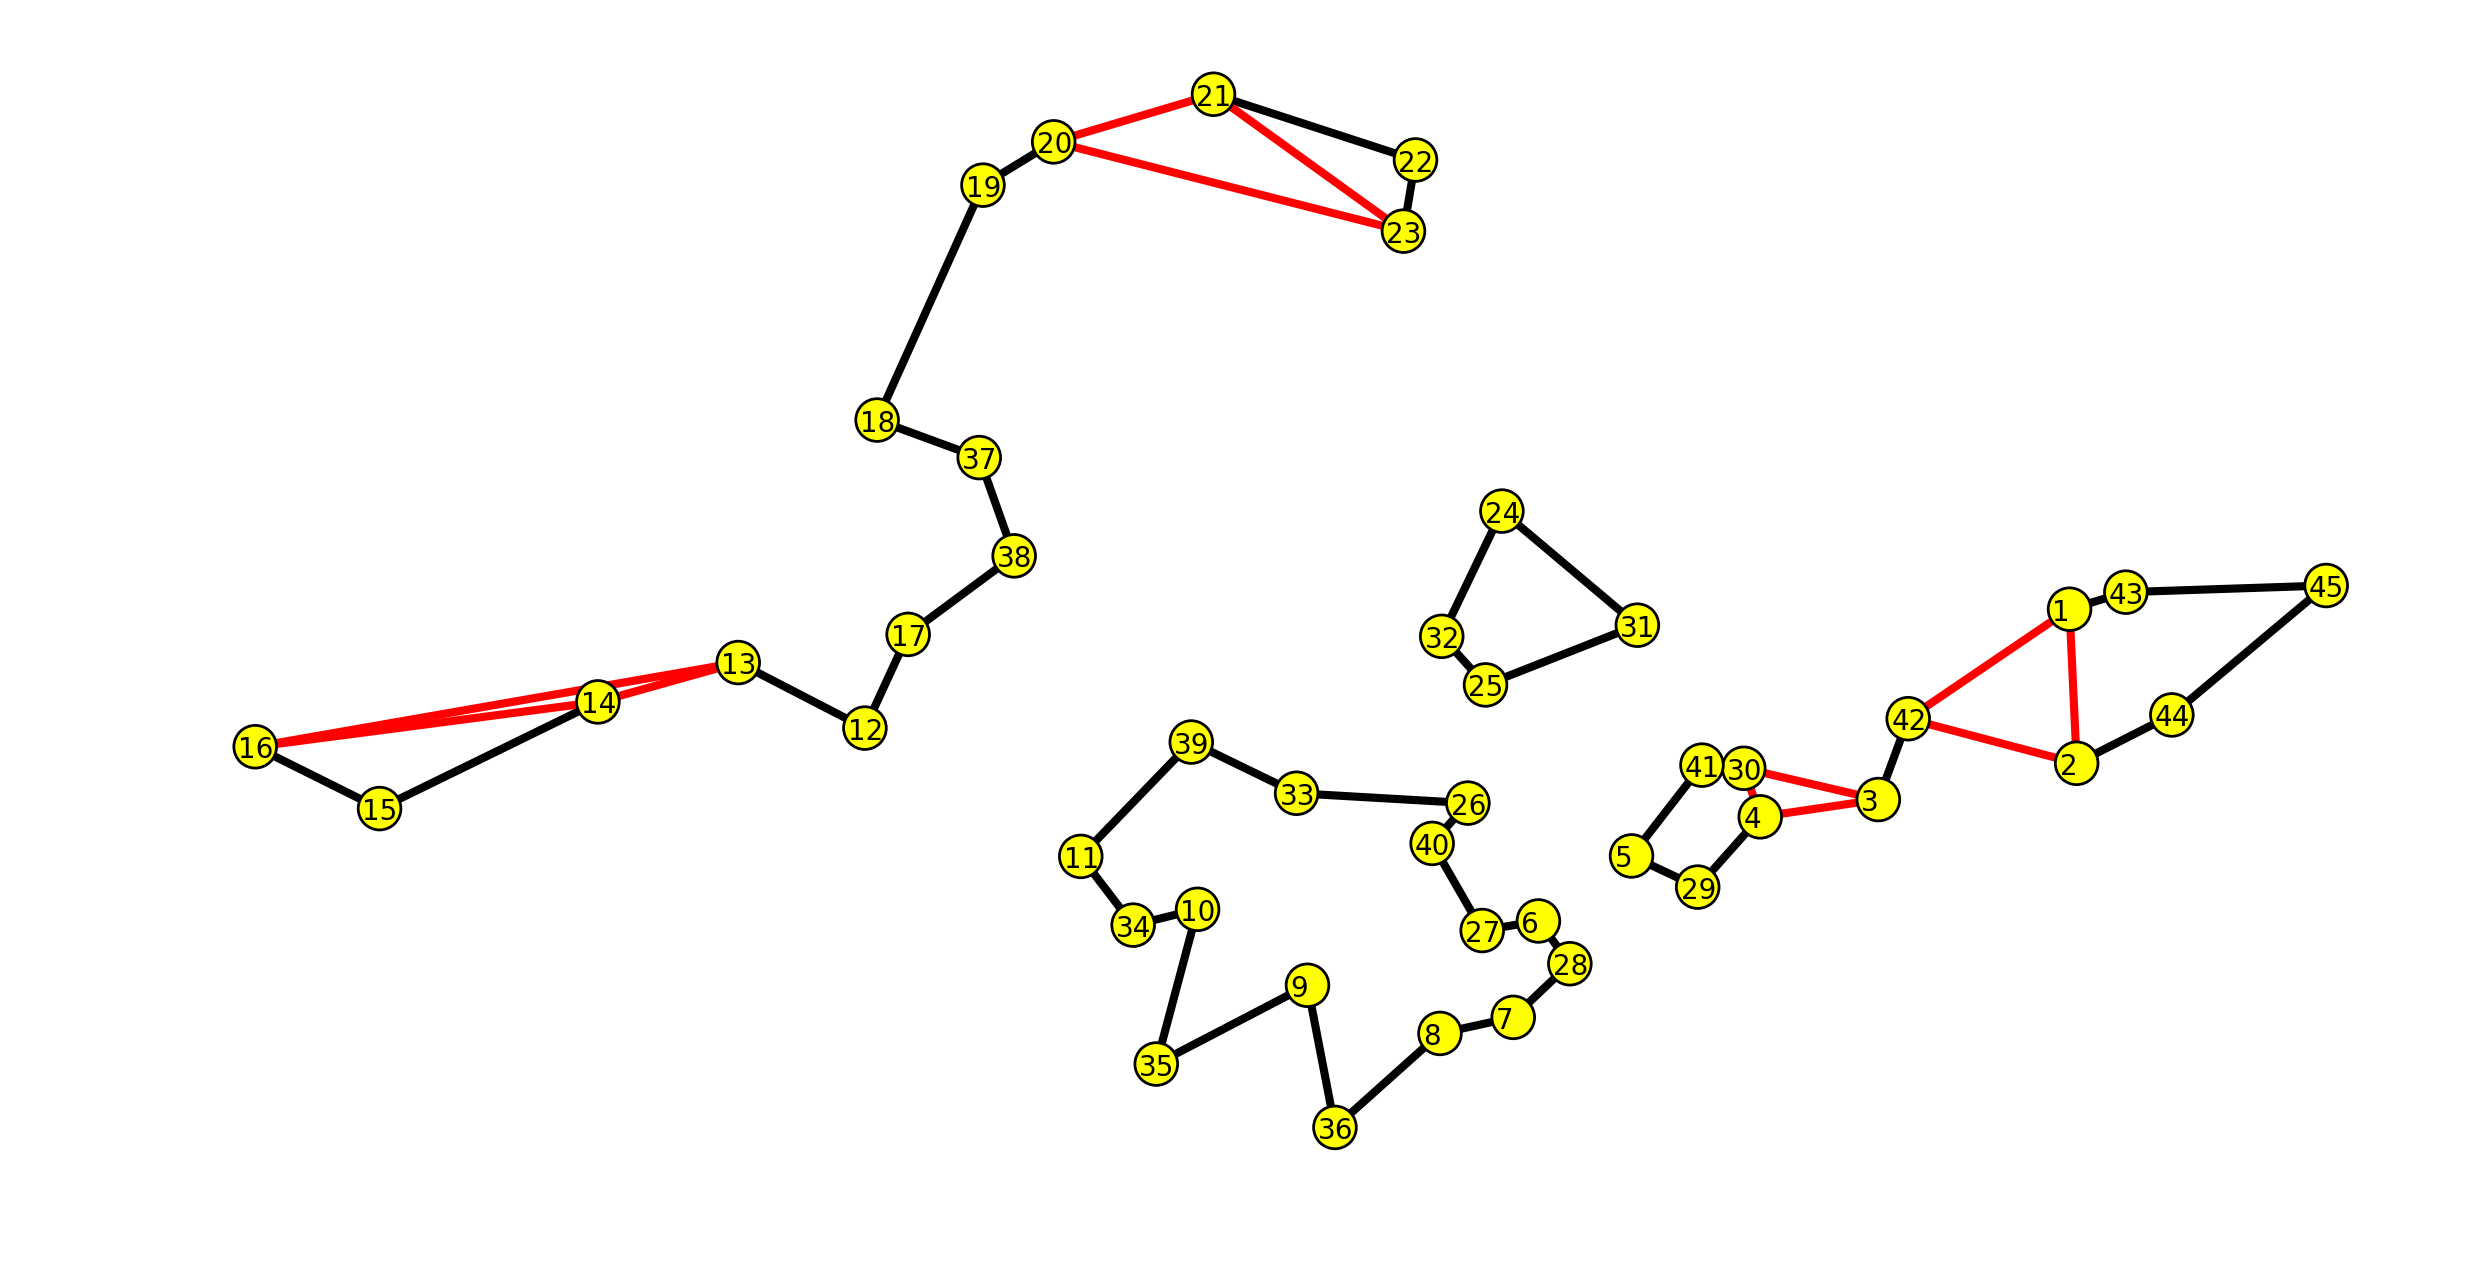

In [14]:
#########################################################################################
#
# Question B2
# B2 Instance Part (2) Plotting the initial graph
#
#########################################################################################
b2_ee, b2_ff = GetFullEdgesAndFractionalEdges(cities_B2_list, B2_X_ij_s)
b2_initial_graph = frac_TSP_plot(b2_ee, b2_ff, cities_B2_list, posn_B2, dist_B2)

In [15]:
#########################################################################################
#
# Question B2
# B2 Instance Part (3) Iteratively subtour elimination
#
#########################################################################################

## Please note that the following subtours are generated iteratively
## and new subtours can be generated whilst eliminating an existing, refer to B1 instance's comments for details

b2_final_subtours = [
    [24,25,31,32],
    [6, 27, 40, 26, 33, 39, 11, 34, 10, 35, 9, 36, 8, 7, 28],
    [13,14,15,16],
    [14,15,16],
    [12,13,14,15,16,17],
    [12,13,14,15,16,17,18,37,38],
    [12,13,14,15,16], 
    [1,2,42,43,44,45],
    [1,2,43,44,45],
    [1,2,3,42,43,44,45]]

## Run the Routine again with the final subtours
b2_prob, B2_X_ij_s = Tsp_L1(cities_B2_list, dist_B2, b2_final_subtours)

## solve the updated b2_prob
b2_prob.solve()

print(LpStatus[b2_prob.status])

print("Minimum Cost: {}".format(value(b2_prob.objective)))

## print the new X_ij_s
Print_Cities_With_Linkage(cities_B2_list, B2_X_ij_s)

Optimal
Minimum Cost: 1223.0
Optimal
Minimum Cost: 1223.0
2  to  44  with value of  1.0
3  to  2  with value of  1.0
4  to  3  with value of  1.0
4  to  29  with value of  1.0
5  to  6  with value of  0.5
5  to  28  with value of  0.5
6  to  28  with value of  0.5
7  to  28  with value of  1.0
8  to  7  with value of  1.0
11  to  12  with value of  1.0
11  to  39  with value of  1.0
12  to  15  with value of  1.0
13  to  14  with value of  1.0
15  to  16  with value of  1.0
16  to  14  with value of  1.0
17  to  13  with value of  1.0
19  to  18  with value of  1.0
20  to  19  with value of  1.0
21  to  20  with value of  1.0
22  to  21  with value of  1.0
23  to  22  with value of  1.0
23  to  24  with value of  1.0
24  to  32  with value of  0.5
25  to  26  with value of  1.0
27  to  6  with value of  1.0
29  to  5  with value of  1.0
30  to  41  with value of  1.0
30  to  42  with value of  1.0
31  to  24  with value of  0.5
31  to  32  with value of  0.5
32  to  25  with value of  

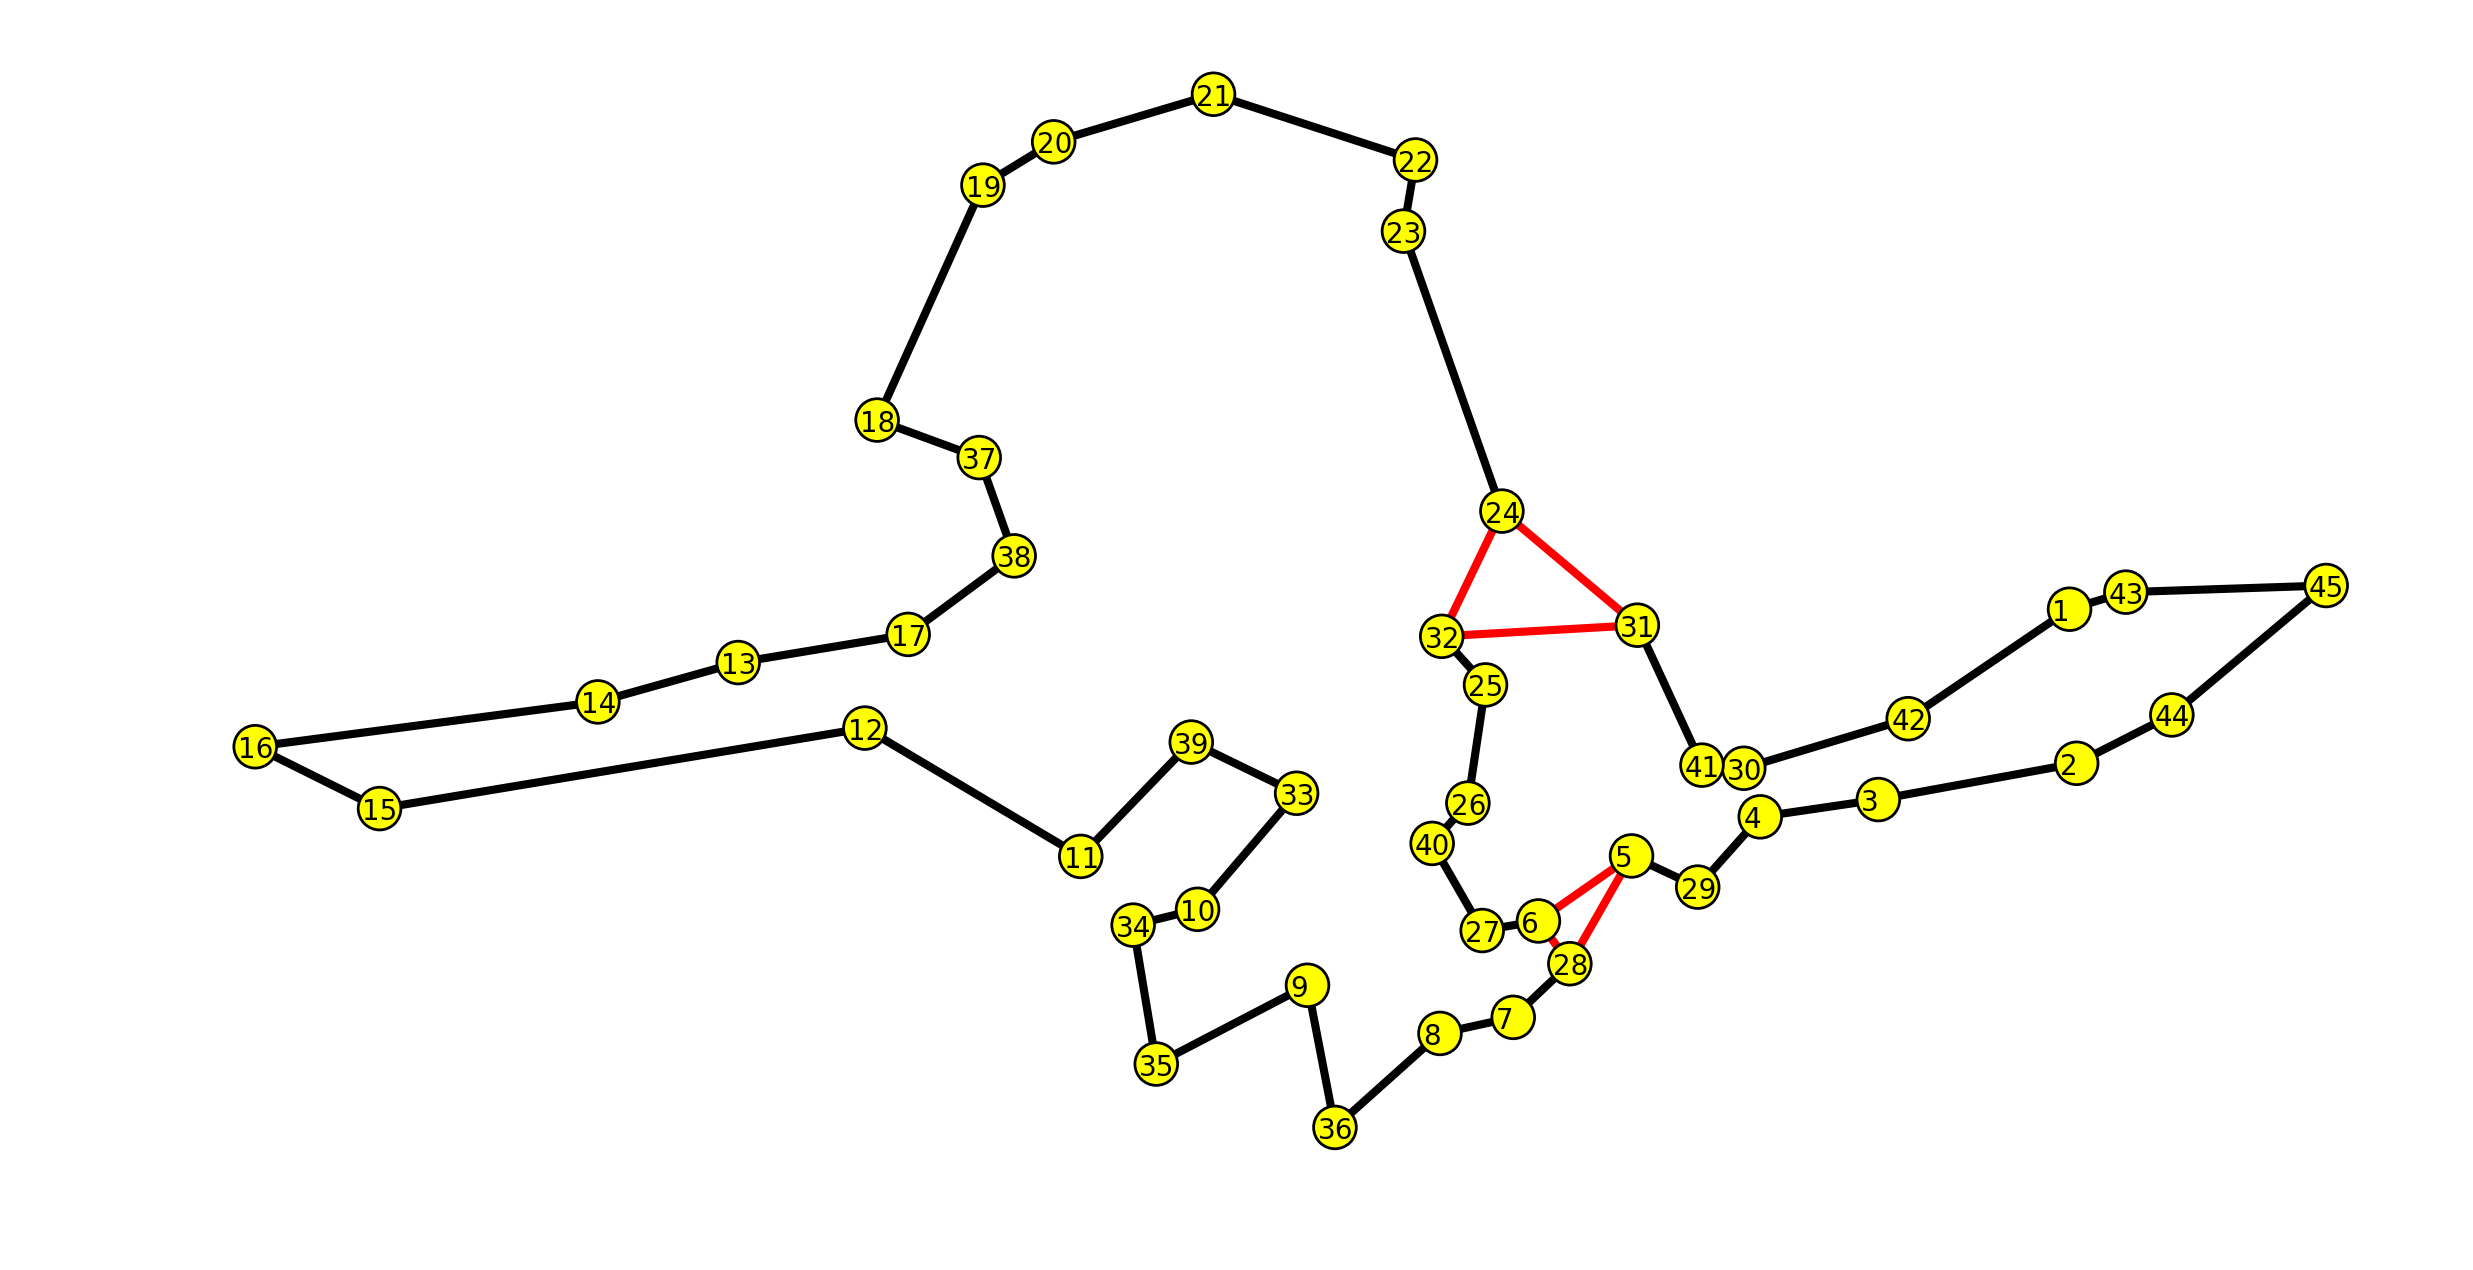

In [16]:
#########################################################################################
#
# Question B2 
# B2 Instance Part (4) Plotting the final graph
#
#########################################################################################
b2_ee_final, b2_ff_final = GetFullEdgesAndFractionalEdges(cities_B2_list, B2_X_ij_s)
b2_final_graph = frac_TSP_plot(b2_ee_final, b2_ff_final, cities_B2_list, posn_B2, dist_B2)

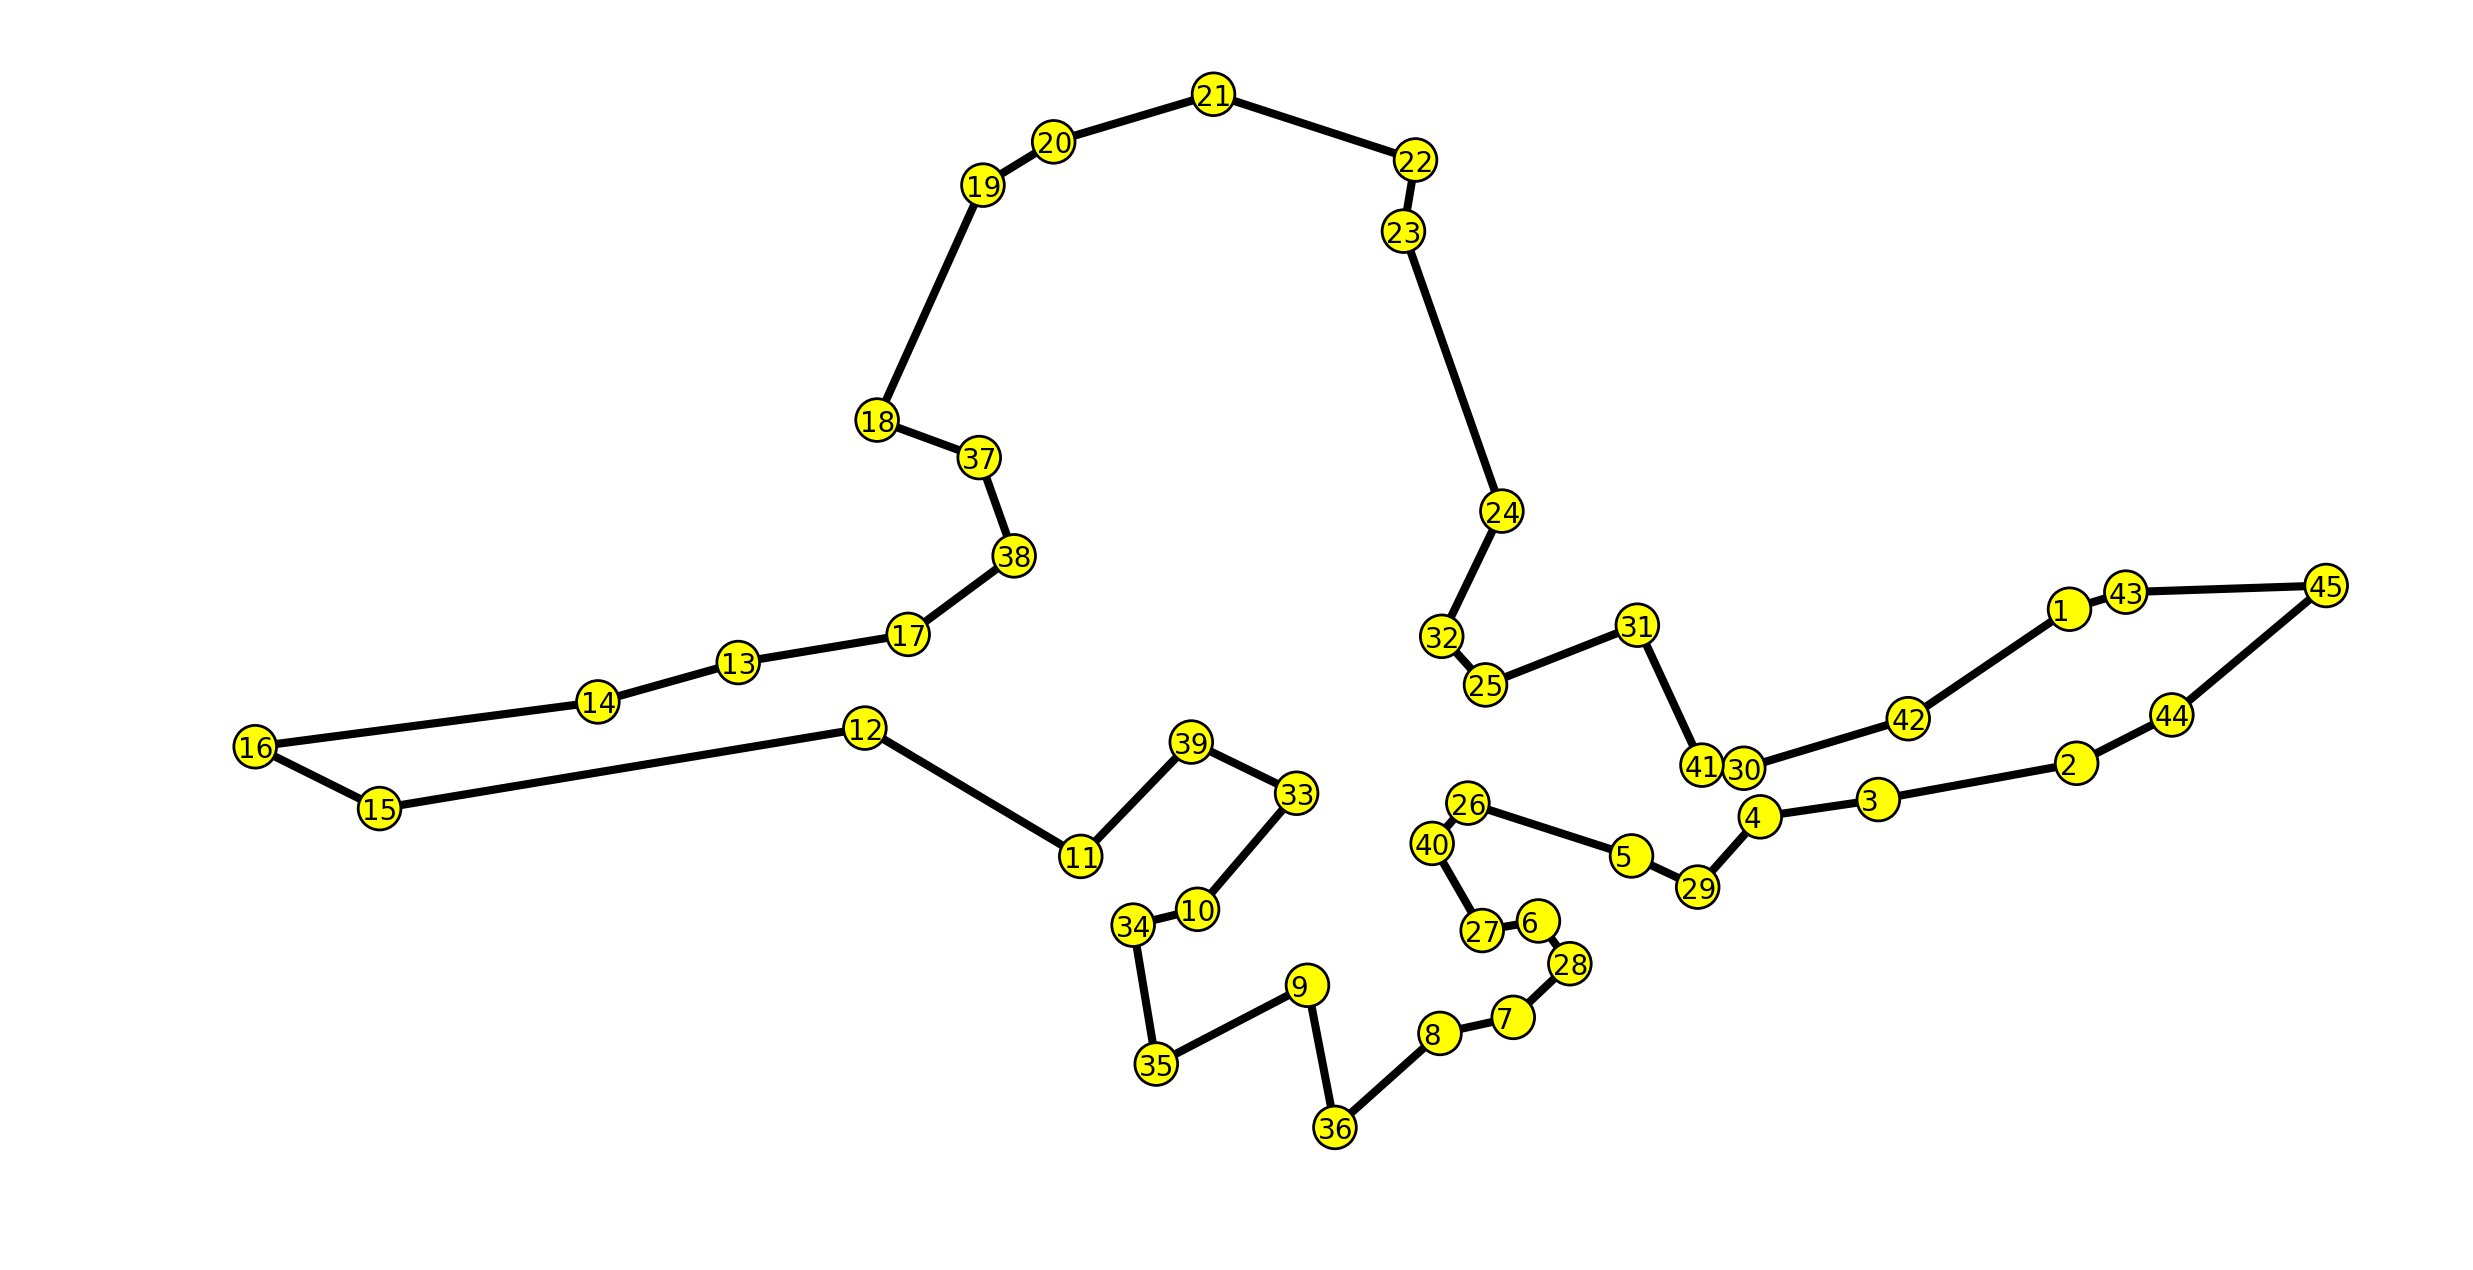

length of candidate TSP tour : 1224


In [17]:
#########################################################################################
#
# Question B2
# B2 Instance Part (5) Plotting the candidate tour
#
#########################################################################################

b2_candidate_tour = [
    16,14,13,17,38,37,18,19,20,21,22,23,24,
    32,25,31,41,30,42,1,43,45,44,2,3,4,29,5,
    26,40,27,6,28,7,8,36,9,35,34,10,33,39,11,12,15
]


b2_L2 = TSP_plot(b2_candidate_tour, cities_B2, posn_B2, dist_B2)
print("length of candidate TSP tour : {}".format(b2_L2))

In [18]:
#########################################################################################
#
# Question B2
# B2 Instance Part (6) Getting the Ration R
#
#########################################################################################

b2_L1  = value(b2_prob.objective)
print("B2 Instance we have achieved L1 of value: {0}".format(b2_L1))
print("B2 Instance we have guessed candidate tour L2 of value: {0}".format(b2_L2))

b2_R  = value(b2_L2) / b2_L1
print("B2 Instance we have achieved Ration R of value: {0}".format(b2_R))




#########################################################################################
#
# End of B2 Instance 
#
#########################################################################################



B2 Instance we have achieved L1 of value: 1223.0
B2 Instance we have guessed candidate tour L2 of value: 1224
B2 Instance we have achieved Ration R of value: 1.0008176614881439


---

## Auxilliary Plotting Functions

In [19]:
# Auxiliary function that
# plots out a candidate TSP tour 
# and computes its length


import matplotlib.pyplot as plt
import math as math
from matplotlib import collections as mc


def TSP_plot(tour,cities,posn,dist):
    fig = plt.figure()
    fig.set_dpi(200)
    fig.set_size_inches(15,30)

    r = 400
    xoffset=-0.8*r
    yoffset=-0.5*r
    displayname = 0

    for city in cities:

        center = posn[city]

        circle = plt.Circle(center, r, ec='black',fc='yellow', zorder = 9)
        plt.text(center[0]+xoffset,center[1]+yoffset,city, zorder=10)
        plt.gca().add_patch(circle)
    
    N = len(cities)
    
    L = 0
    for i in range(N):
        u = tour[i]
        if i<N-1: v = tour[i+1]
        else: v = tour[0]
            
        ux = posn[u][0]
        uy = posn[u][1]
        vx = posn[v][0]
        vy = posn[v][1]
        plt.arrow(ux,uy,vx-ux,vy-uy,color='k',width=100,head_width=0, zorder=1)
        
        L += dist[(u,v)]
        
    plt.axis('scaled')
    plt.axis('off')
    plt.show()
    
    return L

In [20]:
# Auxiliary functions that plots out a fractional TSP tour 
#   E  : list of edges with values one, and plotted in black 
#   fE : list of edges with fractional, and plotted in red 

import matplotlib.pyplot as plt
import math as math
from matplotlib import collections  as mc


def frac_TSP_plot(E,fE,cities,posn,dist):
    fig = plt.figure()
    fig.set_dpi(200)
    fig.set_size_inches(15,30)

    r = 400
    xoffset=-0.8*r
    yoffset=-0.5*r
    displayname = 0

    for city in cities:

        center = posn[city]

        circle = plt.Circle(center, r, ec='black',fc='yellow', zorder = 9)
        plt.text(center[0]+xoffset,center[1]+yoffset,city, zorder=10)
        plt.gca().add_patch(circle)
    
    L = 0
    
    for (u,v) in E:
        ux = posn[u][0]
        uy = posn[u][1]
        vx = posn[v][0]
        vy = posn[v][1]
        plt.arrow(ux,uy,vx-ux,vy-uy,color='k',width=100,head_width=0, zorder=1)
        
        L += dist[(u,v)]
    
    for (u,v) in fE:
        ux = posn[u][0]
        uy = posn[u][1]
        vx = posn[v][0]
        vy = posn[v][1]
        plt.arrow(ux,uy,vx-ux,vy-uy,color='red',width=100,head_width=0, zorder=1)
        
        L += 0.5*dist[(u,v)]
    
        
    plt.axis('scaled')
    plt.axis('off')
    plt.show()
    
    return L